## 0. Importing Libraries

In [1]:
import sys
import itertools

sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from knn import KNN

## 1. Reading the data

In [4]:
def read_file(path, num, magic):
    """
    Read buffer & Convert to ndarray
    (ref: http://yann.lecun.com/exdb/mnist/)
    """
    with open(path, 'rb') as f:
        # Check metadata
        assert f.read(4) == magic.to_bytes(4, byteorder='big'), 'Invalid magic bytes'
        assert f.read(4) == num.to_bytes(4, byteorder='big'), 'Data size mismatch'
        if 'images' in path:
            f.read(8) # field for each datum's size
        data = f.read()
    return np.frombuffer(data, dtype=np.uint8)

In [5]:
train_files = {
    'images': 'data/train-images-idx3-ubyte', 
    'labels': 'data/train-labels-idx1-ubyte'
}
test_files = {
    'images': 'data/t10k-images-idx3-ubyte',
    'labels': 'data/t10k-labels-idx1-ubyte'
}

train_sz = 60000
test_sz = 10000
w, h = 28, 28

In [6]:
train_X = read_file(train_files['images'], num = train_sz, magic = 0x803)
train_y = read_file(train_files['labels'], num = train_sz, magic = 0x801)

test_X = read_file(test_files['images'], num = test_sz, magic = 0x803)
test_y = read_file(test_files['labels'], num = test_sz, magic = 0x801)

# Reshape array
train_X = train_X.reshape((train_sz, -1))
test_X = test_X.reshape((test_sz, -1))

# Check shapes
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [7]:
# Downsample & Scale the dataset (Too much memory cost with original size)

train_X = train_X[:5000]/255
train_y = train_y[:5000]

test_X = test_X[:1000]/255
test_y = test_y[:1000]

# Check shapes
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(5000, 784) (5000,)
(1000, 784) (1000,)


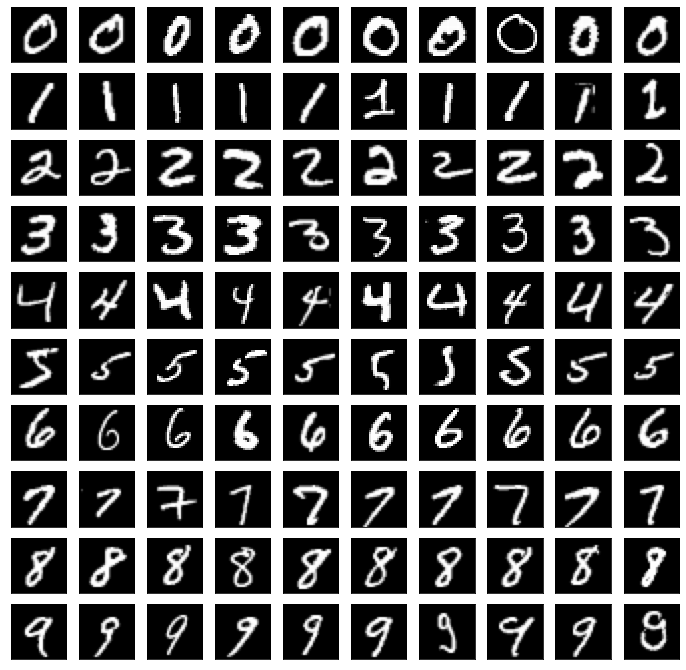

In [8]:
fig, axes = plt.subplots(10, 10, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

for i, j in itertools.product(range(10), range(10)):
    axes[i][j].imshow(train_X[train_y==i][j].reshape((w, h)), cmap='gray')

## 2. Running the Model

In [9]:
clf = KNN(k=5, dist=2)
clf.train(train_X, train_y)

# compute_distances may generate runtime warnings since np.sqrt() can receive
# negative numbers due to floating point errors (check knn.py)
preds = clf.predict(test_X)
print((preds == test_y).mean())

0.91


In [10]:
def cross_validation(params, X, y, fold=3):
    X_folds = np.array_split(X, fold)
    y_folds = np.array_split(y, fold)
    cmb = list(itertools.product(*(params[k] for k in params)))
    scores = {}
    
    for k, dist in cmb:
        print('Trying k={} & dist={}'.format(k, dist))
        scores['k={}, dist={}'.format(k, dist)] = []
        clf = KNN(k=k, dist=dist)
        for f in range(fold):
            _train_X = np.concatenate(np.delete(X_folds, f, 0))
            _train_y = np.concatenate(np.delete(y_folds, f, 0))
            _valid_X = X_folds[f]
            _valid_y = y_folds[f]
            
            clf.train(_train_X, _train_y)
            preds = clf.predict(_valid_X)
            scores['k={}, dist={}'.format(k, dist)].append((preds==_valid_y).mean())
    
    return scores

In [11]:
params = {
    'k': [1, 3, 5, 7, 9],
    'dist': [1, 2]
}

scores = cross_validation(params, train_X, train_y)

L1_scores, L2_scores = [], []
for k, v in scores.items():
    if 'dist=1' in k:
        L1_scores.append(sum(v)/3)
    else:
        L2_scores.append(sum(v)/3)

Trying k=1 & dist=1
Trying k=1 & dist=2
Trying k=3 & dist=1
Trying k=3 & dist=2
Trying k=5 & dist=1
Trying k=5 & dist=2
Trying k=7 & dist=1
Trying k=7 & dist=2
Trying k=9 & dist=1
Trying k=9 & dist=2


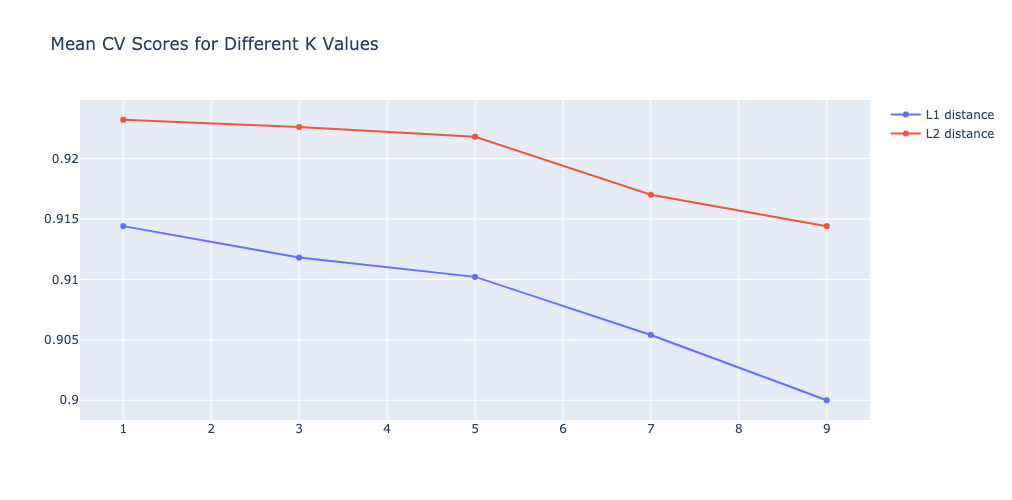

In [31]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[1, 3, 5, 7, 9], y=L1_scores, name='L1 distance'))
fig.add_trace(go.Scatter(x=[1, 3, 5, 7, 9], y=L2_scores, name='L2 distance'))

fig.update_layout(
    autosize=False, width=800, height=500,
    title_text='Mean CV Scores for Different K Values'
)
fig.show()

In [32]:
# Testing with the best parameters

clf = KNN(k=1, dist=2)
clf.train(train_X, train_y)

preds = clf.predict(test_X)
print((preds == test_y).mean())

0.902
